In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from fim_doe import *
import matplotlib.ticker as ticker

In [2]:
from fixed_bed_model_indexed_dynamic import *

alpha option:
1 / (1 + exp(-x))
    Import ComponentSet from pyomo.common.collections.  (deprecated in 5.7.1)
    (called from <frozen importlib._bootstrap>:228)


In [3]:
NFEt = 68
time_scale = 3200
collo = False
exp_time_ = time_points(NFEt, time_scale)

initialize_point = '2021oct8_f303_b293_y40_5e3.csv'

t_measure = exp_time_

prior_all = np.zeros((2,2))

prior_pass=np.asarray(prior_all)


def add_model(doe, timepoints, time_start=0):
    '''
    add variables, equations and discretize the model time
    Argument:
        timepoints: the timesteps
        time_start: where the timesteps start. For self defined timepoints it's 0. For experimental data it's -10.
    '''
    add_variables(doe, timesteps=timepoints, start=time_start)
    
    add_equations(doe)
    
    print ('the number of timepoints is', NFEt)
    
def discretize(doe, no_points=68, collo=False):
    '''
    no_points: how many time invertals to divide. For self defined timepoints it's 69. For experimental data it's 68. 
    here it's 68
    '''
    if collo:
        TransformationFactory('dae.collocation').apply_to(doe, nfe=no_points, ncp=3, scheme='LAGRANGE-RADAU', wrt=doe.t)
    else:
        TransformationFactory('dae.finite_difference').apply_to(doe, nfe=no_points, scheme='BACKWARD', wrt=doe.t)
    
    
def initialize(doe, init_point):
    '''
    Argument: 
        init_point: initial point, csv file
    '''
    # Initialize 
    print('The init point is', init_point)    
    store = pd.read_csv(init_point)
    position_max = store['position'].max()
    store['position'] = store['position'] / position_max

    initial_bed_csv(doe, store)
    fix_initial_bed(doe)
    
def generate_exp(feed, bath, y, const_q):
    initialize_q = {}
    for t in exp_time_:
        initialize_q[t] = const_q
    print(exp_time_[0])
    dv_dict_overall = {'temp_feed': {0: feed}, 'temp_bath': {0:bath}, 'yfeed': {0: y}, 'Q': initialize_q}
    return dv_dict_overall

def model_integrate(scena, args_list, exp_time=exp_time_, init_point=initialize_point):
    test = create_model(scena, temp_feed=293.15, temp_bath=293.15, y=0.15, doe_model=args_list[0], k_aug=args_list[1], opt=False, diff=0)
    add_model(test, exp_time)
    discretize(test)
    initialize(test, init_point)
    return test

In [10]:
parameter_dict = {'fitted_transport_coefficient':212, 'ua': np.log(5.0E6)}
dv_pass = {'temp_feed': None, 'yfeed': None, 'Q':exp_time_}
measurement_pass = Measurements({'FCO2': {19: t_measure}, 'temp': {10: t_measure, 19:t_measure}})

sensi_opt = 'sequential_finite'
# feed, bath, y
exp1 = generate_exp(313.15, 293.15, 0.15, 0)

# choose from model and k_aug 
model_opt = 'doe'

if (model_opt == 'doe'):
    args_ = [True, False]
    
elif (model_opt =='kaug'):
    args_ = [True, True]
    

0


In [11]:
def read_file(output_name): 
    doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                     measurement_pass, model_integrate,
                                    prior_FIM=prior_pass, discretize_model=None)

    result = doe_object.compute_FIM(exp1, mode=sensi_opt, FIM_store_name = 'fixed_bed.csv',
                                   scale_nominal_param_value = True, 
                                    store_output = 'store_output', read_output=output_name,
                                    formula='central')
 
    result.calculate_FIM(doe_object.jac, doe_object.design_values, jaco_involved=None)
    
    return result 
    

In [12]:
path_1 = './Oct25_addQ/'

obj_name1 = 'k_293_293_15_5e6'
obj_name2 = 'k_293_293_15_5e3'
obj_name3 = 'k_313_293_15_5e6'
obj_name4 = 'k_313_293_15_5e3'

change_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#change_list = [0,10,20,30,40,50]

In [13]:
def get_one_case(path, file_name, change):
    
    case_a = []
    case_d = []
    case_e = []
    case_me = []
    for i in change:
        output_n = path+'Q'+str(i)+file_name 
        print(output_n)
        result_iter = read_file(output_n)
        case_a.append(np.log10(result_iter.trace))
        case_d.append(np.log10(result_iter.det))
        case_e.append(np.log10(result_iter.min_eig))
        case_me.append(np.log10(result_iter.cond))
        
    return case_a, case_d, case_e, case_me

case1_a, case1_d, case1_e, case1_me = get_one_case(path_1, obj_name1, change_list)
case2_a, case2_d, case2_e, case2_me = get_one_case(path_1, obj_name2, change_list)
case3_a, case3_d, case3_e, case3_me = get_one_case(path_1, obj_name3, change_list)
case4_a, case4_d, case4_e, case4_me = get_one_case(path_1, obj_name4, change_list)
print(case2_a)
print(case4_a)
print(case2_d)
print(case4_d)

./Oct25_addQ/Q0k_293_293_15_5e6
All measurements are flattened.
Flatten measurement name: ['FCO2_index_19', 'temp_index_10', 'temp_index_19']
Flatten measurement timeset: {'FCO2_index_19': [0, 47.05882352941177, 94.11764705882354, 141.1764705882353, 188.23529411764707, 235.29411764705884, 282.3529411764706, 329.4117647058824, 376.47058823529414, 423.5294117647059, 470.5882352941177, 517.6470588235295, 564.7058823529412, 611.7647058823529, 658.8235294117646, 705.8823529411764, 752.9411764705881, 799.9999999999998, 847.0588235294115, 894.1176470588232, 941.1764705882349, 988.2352941176466, 1035.2941176470583, 1082.35294117647, 1129.4117647058818, 1176.4705882352935, 1223.5294117647052, 1270.5882352941169, 1317.6470588235286, 1364.7058823529403, 1411.764705882352, 1458.8235294117637, 1505.8823529411754, 1552.9411764705872, 1599.9999999999989, 1647.0588235294106, 1694.1176470588223, 1741.176470588234, 1788.2352941176457, 1835.2941176470574, 1882.3529411764691, 1929.4117647058808, 1976.4705

In [8]:
print(case3_d)
print(case2_d)

def improve(det_list):
    print((det_list[-1]-det_list[0])/det_list[0])
    
improve(case3_e)
improve(case3_me)


NameError: name 'case3_d' is not defined

In [9]:
print(case2_d[-1])
imp_a, imp_d, imp_e, imp_me = get_one_case(path_1, obj_name2, [95,105])
print(imp_d)

case2_a[-1] = sum(imp_a)/2 
case2_d[-1] = sum(imp_d)/2 
case2_e[-1] = sum(imp_e)/2 
case2_me[-1] = sum(imp_me)/2 


NameError: name 'case2_d' is not defined

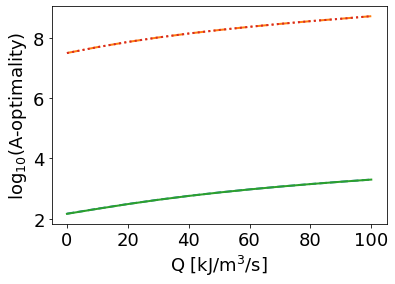

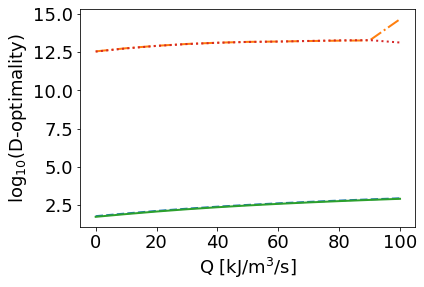

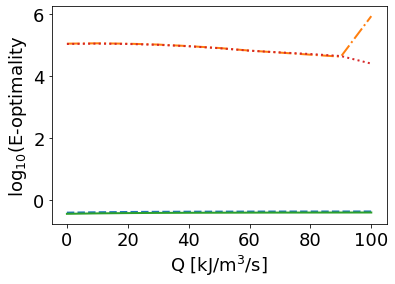

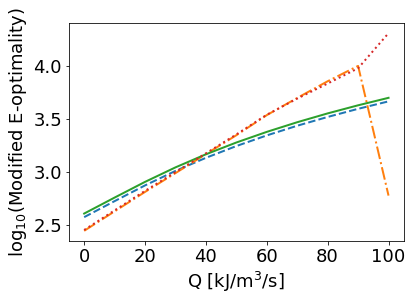

In [20]:
#from matplotlib import rc
def plotting(x_list, ylabel, result_list1, result_list2, result_list3, result_list4):

    si=18
    plt.rc('axes', titlesize=si)
    plt.rc('axes', labelsize=si)
    plt.rc('xtick', labelsize=si)
    plt.rc('ytick', labelsize=si)
    plt.rc('legend', fontsize=14)

    #print(np.shape(x_list))
    plt.plot(x_list, result_list1, linewidth=2, linestyle='--', label='Near isothermal, no Temp difference')
    plt.plot(x_list, result_list2, linewidth=2, linestyle='-.',label='Near adiabatic, no Temp difference')
    plt.plot(x_list, result_list3, linewidth=2, linestyle='-', label='Near isothermal, Temp difference')
    plt.plot(x_list, result_list4, linewidth=2, linestyle=':',label='Near adiabatic, Temp difference')
    
    #plt.legend()
    plt.xlabel('Q [kJ/m$^3$/s]')
    plt.ylabel(ylabel)
    #plt.legend()
    plt.show()


plotting(change_list, 'log$_{10}$(A-optimality)', case1_a, case2_a, case3_a, case4_a)
plotting(change_list, 'log$_{10}$(D-optimality)', case1_d, case2_d, case3_d, case4_d)
plotting(change_list, 'log$_{10}$(E-optimality', case1_e, case2_e, case3_e, case4_e)
plotting(change_list, 'log$_{10}$(Modified E-optimality)', case1_me, case2_me, case3_me, case4_me)

In [ ]:
#path = '/Users/wangjialu/Desktop/fixed_bed_result_Oct2021/bath293_heatmap_5e6/'
path = './2021oct_heatmap/'

general_name = '20211028_heatmap_'


In [ ]:
#prior_293_40 = np.asarray([[ 2.01984000e-02, -1.60468099e-04],
# [-1.60468099e-04 , 1.28050249e-06]])
#prior_353_40 = np.asarray([[ 1.33302899e-02 , -1.16477419e-04],
# [-1.16477419e-04 , 1.03696201e-06]])

#prior_pass = prior_293_40 + prior_353_40
#print(prior_pass)

In [ ]:
def read_heatmap_files(name, jac_involved, prior_update = prior_pass):
    doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                     measurement_pass, model_integrate,
                                    prior_FIM=prior_update, discretize_model=None)

    if_s = True 

    result = doe_object.compute_FIM(exp1, mode=sensi_opt, FIM_store_name = 'fixed_bed.csv',
                                   scale_nominal_param_value = if_s, 
                                    store_output = 'store_output', read_output=name,
                                    formula='central')

    result.calculate_FIM(doe_object.jac, doe_object.design_values, jaco_involved=jac_involved)
    
    return result 


In [ ]:
#x_ranges = [293, 298,303, 308,313, 318,323, 328,333, 338, 343,348,353]
#y_ranges = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275,0.3, 0.325,0.35, 0.375, 0.4]
#y_ranges = [0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275,0.3, 0.325]
x_ranges = [293, 313]
y_ranges = [0.15, 0.4]
y_ranges_name = [15, 40]
#y_ranges_name = [10,125,15, 175,20, 225,25, 275,30, 325,35, 375,40]
#y_ranges_name2 = [10,12.5,15, 17.5,20, 22.5,25, 27.5,30, 32.5,35, 37.5,40]
#y_ranges_name = [10,125,15, 175,20, 225,25, 275,30, 325]
#y_ranges_name2 = [10,12.5,15, 17.5,20, 22.5,25, 27.5,30, 32.5]

def heatmap(measure_include):
    cri_a = np.zeros((len(x_ranges), len(y_ranges)))
    cri_d = np.zeros((len(x_ranges), len(y_ranges)))
    cri_e = np.zeros((len(x_ranges), len(y_ranges)))
    cri_me = np.zeros((len(x_ranges), len(y_ranges)))

    for i, iname in enumerate(x_ranges):
        for j, jname in enumerate(y_ranges_name):
            print('The feed temperature:', iname, ', feed fraction:', jname)
            file_name = path + general_name +str(iname) + '_' + str(jname)
            result = read_heatmap_files(file_name, measure_include)
            cri_a[i,j] = result.trace
            cri_d[i,j] = result.det
            cri_e[i,j] = result.min_eig
            cri_me[i,j] = result.cond 
    return cri_a, cri_d, cri_e, cri_me
        

In [ ]:
#cri_a_both, cri_d_both, cri_e_both, cri_me_both = heatmap({'FCO2':[19]}) 
#cri_a_both, cri_d_both, cri_e_both, cri_me_both = heatmap({'FCO2':[19], 'temp':[19]}) 
cri_a_both, cri_d_both, cri_e_both, cri_me_both = heatmap(None) 

In [ ]:
base_a = 0.0017594191141218354
base_d = 7.264846556201249e-12
base_e = 4.129126225567167e-09
base_me = 426098.61963082536

both_a = 1.4536801050859183
both_d = 0.005286990035325208
both_e = 0.0036461145530681804
both_me = 397.69293296412104

print((both_me-base_me)/base_me)

In [ ]:
ori_a = 1.4536801050859183
opt_a = 2.796373796492053
ori_d = 0.005286990035325208
opt_d = 0.09059289902791555
ori_e = 0.0036461145530681804
opt_e = 0.03278084018163918
ori_me = 397.69293296412104
opt_me = 84.30512888008055

print((opt_me-ori_me)/ori_me)

In [ ]:
if False:
    cri_a_data = pd.DataFrame(cri_a_both)
    cri_d_data = pd.DataFrame(cri_d_both)
    cri_e_data = pd.DataFrame(cri_e_both)
    cri_me_data = pd.DataFrame(cri_me_both)
    
    cri_a_data.to_csv('20211028_5e6_onlyF_2prior_a.csv')
    cri_d_data.to_csv('20211028_5e6_onlyF_2prior_d.csv')
    cri_e_data.to_csv('20211028_5e6_onlyF_2prior_e.csv')
    cri_me_data.to_csv('20211028_5e6_onlyF_2prior_me.csv')

In [ ]:

def draw_heatmap(cri_a, cri_type='A'):
    
    if cri_type=='A':
        colorbar_name = 'log$_{10}$(A-optimality)'
    elif cri_type=='D':
        colorbar_name = 'log$_{10}$(D-optimality)'
    if cri_type=='E':
        colorbar_name = 'log$_{10}$(E-optimality)'
    if cri_type=='ME':
        colorbar_name = 'log$_{10}$(ME-optimality)'
    
    hes_a = np.log10(cri_a)
    
    
    
    fig = plt.figure()
    plt.rc('axes', titlesize=16)
    plt.rc('axes', labelsize=16)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    ax = fig.add_subplot(111)
    params = {'mathtext.default': 'regular'}
    plt.rcParams.update(params)
    
    ax.set_yticks(range(len(y_ranges_name2)))
    ax.set_yticklabels(y_ranges_name2)
    loc = ticker.MultipleLocator(base=2)
    ax.yaxis.set_major_locator(loc)
    ax.set_ylabel('CO$_2$ feed fraction [mol %]')
    
    ax.set_xticks(range(len(x_ranges)))
    ax.set_xticklabels(x_ranges)
    loc = ticker.MultipleLocator(base=2)
    ax.xaxis.set_major_locator(loc)
    ax.set_xlabel('Feed temperature [K]')
    im = ax.imshow(hes_a.T, cmap=plt.cm.hot_r)
    ba = plt.colorbar(im)
    ba.set_label(colorbar_name,labelpad=-40, y=1.1, rotation=0)
    #?plt.title(title_text + ' - A optimality')
    plt.show()
    
draw_heatmap(cri_a_both)
draw_heatmap(cri_d_both, cri_type='D')
draw_heatmap(cri_e_both, cri_type='E')
draw_heatmap(cri_me_both, cri_type='ME')

In [ ]:
def heatmap_make(result,opt):
    xLabel=list(np.linspace(1,5,20))
    xLabel = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
    #xLabel=np.arange(1,5,0.5)
    yLabel=list(np.linspace(300,700,20))
    print(yLabel)
    yLabel = [300, 321, 342, 363, 384, 405, 426, 447, 468, 489, 511, 532, 553, 574, 595, 616, 637, 658, 679, 700.0]
    fig=plt.figure()

    si=16
    plt.rc('axes', titlesize=si)
    plt.rc('axes', labelsize=si)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=14)
    ax=fig.add_subplot(111)
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    loc = ticker.MultipleLocator(base=2)
    ax.yaxis.set_major_locator(loc)
    ax.set_ylabel('$T$ [K]')
    
    # xticks
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    loc = ticker.MultipleLocator(base=2)
    ax.xaxis.set_major_locator(loc)
    #ax.set_xticks(ax.get_xticks()[::4])
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    
    #for label in ax.get_xticklabels()[::2]:
    #    label.set_visible(False)
    
    ax.set_xlabel('$C_{A0}$ [M]')
    im=ax.imshow(result.T, cmap=plt.cm.hot_r)
    ba=plt.colorbar(im)
    ba.set_label('$log_{10}$('+opt+'-optimality)',labelpad=-40, y=1.1, rotation=0)
    #plt.title('DoE for Fixed Bed Model (k)')
    plt.show

In [ ]:
import os
#design_ranges = [[298, 308, 318, 328, 338, 348,353], [0.125, 0.175, 0.225, 0.275, 0.325, 0.375]]
#design_ranges= [[293, 303, 313, 323, 333, 343],[0.125, 0.175, 0.225, 0.275, 0.325, 0.375]]
design_ranges = [[293,298, 303, 308, 313,318, 323,328, 333,338, 343,348, 353]
    , [10,125,15,175,20,225,25,275,30,325,35,375,40]]

if False:
    for i, iname in enumerate(design_ranges[0]):
        for j, jname in enumerate(design_ranges[1]):
            no = i*len(design_ranges[1]) + j
            old_name = r'/Users/wangjialu/pyomo/pyomo/contrib/doe/20211031_heatmap' + str(no)
            new_name = r'/Users/wangjialu/pyomo/pyomo/contrib/doe/20211031_heatmap_' +str(iname) +'_'+str(int(jname))+'_5e3'
            os.rename(old_name, new_name)